In [1]:
import numpy as np

from sleep_eeg.pre_processing.mq import *
from sleep_eeg.utils import *

import matplotlib.pyplot as plt

from skorch import NeuralNetClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
import random

from torch.nn.functional import relu
import torch.nn as nn
import torch

import pickle

from sklearn.preprocessing import StandardScaler

# 1. Process epoch data

## 1.1 Load the data

In [2]:
with open("../data/eeg/dict_features_416_108.pkl", "rb") as f:
    dict_features_416_108 = pickle.load(f)

In [3]:
dict_features_416_108["A1_N3"].shape

(416, 32, 26)

In [4]:
data = np.array([val for val in dict_features_416_108.values()])
data.shape

(108, 416, 32, 26)

In [5]:
nights = [key for key in dict_features_416_108.keys()]
len(nights)

108

In [6]:
night_names = rename_nights(nights)
len(night_names)

108

## 1.2. Load MQ

In [7]:
mq = load_mq_file()
mq = make_classification(mq)
mq = mq.drop(
    columns=[
        "Group",
        "Participant",
        "Night",
        "Drug",
        "mq_1_Sleeplatency",
        "mq_2_times_awake",
        "mq_3_time_lay_awake",
    ]
)
mq = mq.drop(mq.index.difference(night_names))
mq = mq.reindex(pd.Index(night_names).intersection(mq.index))
mq

,mq_4_calm_sleep,mq_5_superficial_sleep,mq_6_recovery,mq_7_bad_mood,mq_8_energy,mq_9_tense,mq_10_unconcentrated
A01_N3,1,1,0,1,1,3,2
A01_N4,0,3,0,3,0,3,3
A01_N5,1,2,2,3,1,3,1
A10_N3,3,2,0,0,1,3,3
A10_N4,0,3,0,3,0,3,3
...,...,...,...,...,...,...,...
B08_N4,0,2,1,3,0,2,3
B08_N5,0,3,1,1,1,2,1
B09_N3,1,2,3,1,3,1,0
B09_N4,0,3,2,1,2,1,1


In [8]:
compatible_data = np.delete(
    data,
    [
        night_names.index(not_in_mq)
        for not_in_mq in pd.Index(night_names).difference(mq.index)
    ],
    axis=0,
)
compatible_data.shape

(106, 416, 32, 26)

## 1.3. Look at FFT features

In [9]:
fft_data = compatible_data[:, :, :16, :].reshape(106, 1, 416, 416)
fft_data.shape

(106, 1, 416, 416)

In [10]:
mq["mq_4_calm_sleep"].to_numpy()

array([1, 0, 1, 3, 0, 0, 2, 3, 2, 3, 3, 2, 1, 1, 3, 0, 3, 3, 2, 3, 0, 1,
       3, 1, 2, 2, 3, 1, 1, 2, 3, 3, 1, 2, 1, 3, 3, 3, 1, 2, 0, 3, 0, 3,
       0, 0, 3, 3, 3, 2, 2, 1, 0, 2, 3, 2, 2, 0, 0, 0, 0, 0, 3, 3, 1, 1,
       0, 3, 1, 1, 1, 1, 0, 1, 3, 1, 2, 0, 1, 1, 2, 1, 1, 3, 0, 1, 0, 1,
       2, 1, 3, 3, 3, 0, 0, 0, 0, 1, 1, 2, 3, 0, 0, 1, 0, 2])

## 1.4 Standardise each image

In [11]:
std_fft_data = (
    StandardScaler().fit_transform(fft_data.reshape(106, -1)).reshape(fft_data.shape)
)
std_fft_data.shape

(106, 1, 416, 416)

In [12]:
from scipy.stats import zscore

In [13]:
zscore_fft_data = zscore(fft_data, axis=2)
zscore_fft_data.shape

(106, 1, 416, 416)

## 1.5 Plot resulting images

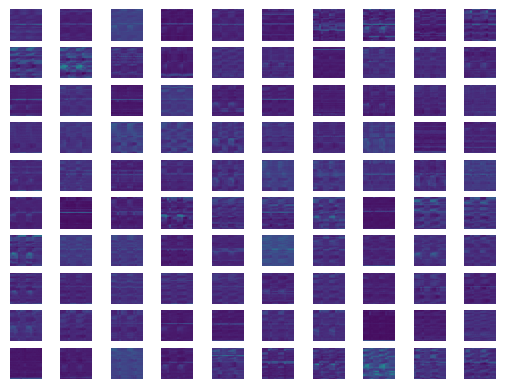

In [22]:
fig, axes = plt.subplots(nrows=10, ncols=10)

for i, ax in enumerate(axes.flatten()):
    ax.imshow(zscore_fft_data[i, 0])
    ax.set_axis_off()

# 2. Train VGG

In [14]:
del data
del compatible_data
del dict_features_416_108
del fft_data
del std_fft_data

In [15]:
from skorch.dataset import ValidSplit
import skorch
from sleep_eeg.models.vgg19 import VGG19

In [16]:
random_state = 0
random.seed(random_state)
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.use_deterministic_algorithms(True)

net = NeuralNetClassifier(
    VGG19,
    max_epochs=10,
    criterion=nn.CrossEntropyLoss,
    lr=1e-2,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    batch_size=2,
    optimizer=torch.optim.Adam,
    train_split=ValidSplit(cv=5, stratified=True, random_state=None),
    callbacks=[
        ("valid_f1", skorch.callbacks.EpochScoring("f1_weighted", name="valid_f1")),
        (
            "train_f1",
            skorch.callbacks.EpochScoring(
                "f1_weighted", name="train_f1", on_train=True
            ),
        ),
    ],
    warm_start=True,
)
net.fit(
    zscore_fft_data.astype(np.float32),
    mq["mq_4_calm_sleep"].to_numpy(dtype=np.int64),
)

/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  epoch    train_f1         train_loss    valid_acc    valid_f1     valid_loss       dur
-------  ----------  -----------------  -----------  ----------  -------------  --------
      1      0.2374  306807142901.3322       0.2727      0.1169  12388830.1818  763.6028
      2      0.2561  2012733562.2143       0.2727      0.1169  356149266.9091  773.3532
      3      0.2332  5614704270.6458       0.2727      0.1169   711920.2557  810.1160
      4      0.3122  786984040.6480       0.2727      0.1212     3523.0462  812.5804
      5      0.3410  14392863520.6085       0.2727      0.1169        1.7261  800.8280
      6      0.2772        1.6719       0.2727      0.1169        1.4175  800.6404
      7      0.2802        1.4383       0.2727      0.1169        1.3965  828.2342
      8      0.1794        1.5547       0.2727      0.1169        1.3924  821.7432
      9      0.2026        1.4320       0.2727      0.1169        1.3960  817.6396
     10      0.2307        1.4330       0.1818      0.0

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=VGG19(
    (in_conv): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (vgg): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=T